# ANLP 2019 - Assignment 2


*Rodrigo Lopez Portillo Alcocer, * (enter your name/student id number here)

<div class="alert alert-block alert-danger">Due: Wednesday, November 20</div>

<div class="alert alert-block alert-info">
**NOTE**<br><br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-1.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle upload (we will provide a link). In case of questions, you can contact David, Bethany or Patrick via email, or via the Moodle forum (preferred).<br><br>
<b>For this assignment, do NOT use any external packages (NLTK or any others) EXCEPT where specified.</b>
</div>

<div class="alert alert-block alert-info">
In this assignment, you will implement and work with a Naive Bayes classifier. (Note that for this exercise, you don't need to represent the input as a vector necessarily. You can directly look at the presence of words, and look up the class conditional likelihood.)
<br>
<br>
We will use a Twitter dataset classified into "hate speech" and "non hate speech" (in our data, we have called these classes "offensive" and "nonoffensive" to avoid the charged and inaccurate term "hate speech"). First, load the data (we have provided the function for this):
</div>

In [392]:
import csv
import simplejson as json
from nltk.tokenize import TweetTokenizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def read_hate_tweets (annofile, jsonfile):
    """Reads in hate speech data."""
    all_data = {}
    annos = {}
    with open(annofile) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            if row[0] in annos:
                # if duplicate with different rating, remove!
                if row[1] != annos[row[0]]:
                    del(annos[row[0]])
            else:
                annos[row[0]] = row[1]

    tknzr = TweetTokenizer()
                
    with open(jsonfile) as jsonfile:
        for line in jsonfile:
            twtjson = json.loads(line)
            twt_id = twtjson['id_str']
            if twt_id in annos:
                all_data[twt_id] = {}
                all_data[twt_id]['offensive'] = "nonoffensive" if annos[twt_id] == 'none' else "offensive"
                all_data[twt_id]['text_tok'] = tknzr.tokenize(twtjson['text'])

    # split training and test data:
    all_data_sorted = sorted(all_data.items())
    items = [(i[1]['text_tok'],i[1]['offensive']) for i in all_data_sorted]
    splititem = len(all_data)-3250
    train_dt = items[:splititem]
    test_dt = items[splititem:]
    print('Training data:',len(train_dt))
    print('Test data:',len(test_dt))

    return(train_dt,test_dt)

TWEETS_ANNO = 'NAACL_SRW_2016.csv'
TWEETS_TEXT = 'NAACL_SRW_2016_tweets.json'

(train_data,test_data) = read_hate_tweets(TWEETS_ANNO,TWEETS_TEXT)


Training data: 12896
Test data: 3250


<div class="alert alert-block alert-info">
Each item in our data consists of a tuple of the tweet text and its label (represented as a string). The tweet text has been tokenized and is represented as a list of words. We can look at an example item:
</div>

In [407]:
test_data[400][1]

'nonoffensive'

## Problem 1: Evaluation

<div class="alert alert-block alert-info">
The first thing you're being asked to do is to provide evaluation functions for a classifier and a given labelled test set. Assume that the classifier has a `predict()` function that takes an item in the form of a list as above and predicts a class for that item. Write evaluation functions to compute the `accuracy` and `f_1` score for such a classifier.
<div>

In [472]:
def accuracy(classifier, data):
    """Computes the accuracy of a classifier on reference data.

    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The accuracy of the classifier on the test data, a float.
    """
    # TODO: Replace the following line with your own code
    # We will assume that the labelled test data has the same structure as the data loaded above (x[0] is the text and x[1] the label)
    # first we will create a binary list storing if the prediction was correct or not
    predict_reviewed = [classifier.predict(text[0]) == text[1] for text in data]
    # accuracy = number of correct predictions / total number of predictions
    return np.sum(predict_reviewed) / len(predict_reviewed)

def f_1(classifier, data):
    """Computes the F_1-score of a classifier on reference data.

    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The F_1-score of the classifier on the test data, a float.
    """
    # TODO: Replace the following line with your own code
    # Same assumption as before and assuming the labels are 1 and 0 for positive and negative
    # In order to compute the F1 score we will calculate first both precision and recall
    true_pos = np.sum([classifier.predict(text[0]) =='offensive' and text[1]=='offensive' for text in data])
    false_pos = np.sum([classifier.predict(text[0])=='offensive' and text[1]=='nonoffensive' for text in data])
    false_neg = np.sum([classifier.predict(text[0])=='nonoffensive' and text[1]=='offensive' for text in data])
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    return 2*precision*recall/(precision+recall)


## Problem 2: Naive Bayes Classifier

<div class="alert alert-block alert-info">
Next, implement the Naive Bayes classifier from scratch using the code skeleton below and the definitions from class.<br><br>
Some requirements and notes for implementation:
<ul>
<li>You should allow for an arbitrary number of classes (in particular, you should not hard code the two classes needed for the given dataset). 
<li>The vocabulary of your classifier should be created dynamically from the training data. (The vocabulary is the set of all words that occur in the training data.).
<li>Use additive smoothing with a provided parameter k. 
<li>You may encounter unknown words at test time. Since we're not allowed to "peek" into the test set, we will implement the following simple treatment: We will assume that we don't know anything about unknown words and that in particular, their presence does not tell us anything about which class a document should be assigned to. Therefore, we will not include them in the calculation of the (log) probabilities during prediction, under the assumption that their probability does not differ hugely between the different classes (probably not a correct assumption, but the best we can do at this point). Since we don't need correct probabilities but only most likely classes, just ignore unknown words during prediction.
<li> Use log probabilities in order to avoid underflow.
</ul>

<div>

In [503]:
class NaiveBayes(object):
    
    def __init__(self):
        """Initialises a new classifier."""
        # TODO: Replace the following line with your own code
        self.voc = dict()
        self.counts = list()
        self.totals = list()
        pass

    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        # TODO: Replace the following line with your own code
        x = [word.lower() for word in x]
        classes = list(self.voc.keys()) #get list of all classes
        probs = np.ones([len(classes), len(x)+1]) # initialize matrix with probabilities
        #the +1 is to add a column with the probabilities of each category from self.totals
        for i in range(len(classes)): #scanning all classes
            for j in range(len(x)): #scanning all words
                if x[j] in self.voc[classes[i]].keys(): #if the word appears in the class
                    probs[i][j] = self.voc[classes[i]][x[j]] 
                else: #if it doesn't we'll assign a value of 1
                    probs[i][j] = 1
        for i in range(len(classes)):
            probs[i][-1] = self.totals[i]
        results = np.array([1, len(classes)]) #here we will store the computed probabilities
        results = [np.prod(probs[i]) for i in range(len(probs))]
        return classes[np.argmax(results)]
    
    def CountFrequency(self, my_list): 
        freq = {} 
        for item in my_list: 
            if (item in freq): 
                freq[item] += 1
            else: 
                freq[item] = 1
        return freq

        
    @classmethod
    def train(cls, data, k=1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        self = cls()
        #we will create a dictionary with the word counts for each class
        #voc = dict()  #voc by classes
        #counts = list() #ith element will contain the total number of words in ith class
        for i in range(len(data)):
            temp = dict() #we will store here the frequency counts for the current line
            v = data[i] #vector with line tokens
            c = v[1] #class
            if (c not in self.voc): #if the class has never been seen before add it to the dictionary
                self.voc[c] = dict()
            new_words = [x.lower() for x in v[0]] #making sure all our new words are in lower case to avoid repetitions
            temp = CountFrequency(new_words) # add the freq counts for the new vocab to the temporary dictionary
            self.voc[c] = Counter(self.voc[c]) + Counter(temp)#updating our current dictionary
        
        #counting probability of each class based on number of words
        self.totals = [np.sum(list(self.voc[key].values())) for key in self.voc.keys()]
        total = np.sum(self.totals)
        self.totals = [self.totals[i]/total for i in range(len(self.totals))]
        
        # k-smoothing
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] += k

        # to get the probabilities now we only have to count all words in each class and normalize
        i=0
        for cla in self.voc:
            t = 0
            for word in self.voc[cla]:
                t += self.voc[cla][word]
            self.counts.append(t)
            i+=1

        # now we normalize our values
        j = 0
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] /= self.counts[j]
            j +=1
        
        # and we apply log likelihood
        # probably all this could fit in the same for loop but no time to re structure rn
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] = np.abs(np.log(self.voc[cla][word])) 
                
        return self

<div class="alert alert-block alert-info">
Evaluate your classifier by training and testing it on the given data. Vary the smoothing parameter k. What happens when you decrease k? Plot a graph of the accuracy and/or f-score given different values of k. Discuss your findings.<div>

In [545]:
nb0 = NaiveBayes.train(train_data, 0)
#nb1 = NaiveBayes.train(train_data, 1)
nb5 = NaiveBayes.train(train_data, 5)
#nb200 = NaiveBayes.train(train_data, 200)
acc_0 = accuracy(nb0, test_data)
#acc_1 = accuracy(nb1, test_data)
acc_5 = accuracy(nb5, test_data)
#acc_200 = accuracy(nb200, test_data)
f1_0 = f_1(nb0,test_data)
#f1_1 = f_1(nb1,test_data)
f1_5 = f_1(nb5,test_data)
#f1_200 = f_1(nb200,test_data)
#print("Accuracy for k=0: ",acc_0)
#print("Accuracy for k=1: ",acc_1)
#print("Accuracy for k=5: ",acc_5)
#print("Accuracy for k=200: ",acc_200)
#print("F_1 for k=0: ", f1_0)
#print("F_1 for k=1: ", f1_1)
#print("F_1 for k=5: ", f1_5)
#print("F_1 for k=200: ", f1_200)

In [536]:
#now that everything seems to work out we can compute several f_1 scores to compare them
ks = np.arange(0, 20, 5)
ks = np.append(ks,25)
ks = np.append(ks,40)
ks = np.append(ks,60)
ks = np.append(ks,90)
ks = np.append(ks,120)
k_values = []
NB = [NaiveBayes.train(train_data, k) for k in ks]

In [546]:
scores_acc = [accuracy(NB[i], test_data) for i in range(len(NB))]
scores_f1 = [f_1(NB[i], test_data) for i in range(len(NB))]

Text(0.5, 1.0, 'F1 Score Variation')

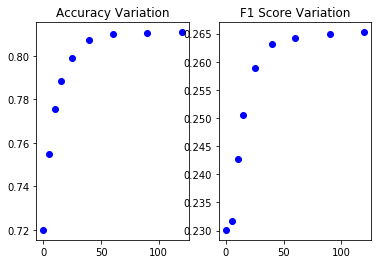

In [547]:
#now we can compute several accuracy values to compare them

plt.figure()

#accuracies
plt.subplot(121)
plt.plot(ks, scores_acc, 'bo')
plt.title("Accuracy Variation")


#f1 score
plt.subplot(122)
plt.plot(ks, scores_f1, 'bo')
plt.title("F1 Score Variation")

Not the nicest plot but it would seem that the higher our k value is, the higher our f_1 score. At least up to a certain k this might be true, but after k passes a certain threshold the smoothing will be too much for and the original counts will be irrelevant. This would in turn lead to a meaningless analysis. We observe very similar result behaviour for the accuracy.

## Problem 3: Feature Engineering

<div class="alert alert-block alert-info">
We mentioned that the Naive Bayes classifier can be used with many different feature types. Try to improve on the basic bag of words model by changing the feature list of your model. Implement at least two variants. For each, explain your motivation for this feature set, and test the classifier with the given data. Briefly discuss your results!<br><br> 
Ideas for feature sets that were mentioned in class include:
<ul>
<li>removing stop words or frequent words
<li>stemming or lemmatizing (you can use NLTK or spacy.io for basic NLP operations on the texts)
<li>introducing part of speech tags as features (how?)
<li>bigrams
</ul>
<div>

In [548]:
#The first feature we will try to implement is to delete from the word counts the 5% most frequent words because they are likely
# to be irrelevant to our analysis.
class NaiveBayes_feature1(object):
    
    def __init__(self):
        """Initialises a new classifier."""
        # TODO: Replace the following line with your own code
        self.voc = dict()
        self.counts = list()
        self.freq = list()
        self.totals = list()
        pass

    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        # TODO: Replace the following line with your own code
        x = [word.lower() for word in x]
        classes = list(self.voc.keys()) #get list of all classes
        probs = np.ones([len(classes), len(x)]) # initialize matrix with probabilities
        for i in range(len(classes)): #scanning all classes
            for j in range(len(x)): #scanning all words
                if x[j] in self.voc[classes[i]].keys(): #if the word appears in the class
                    probs[i][j] = self.voc[classes[i]][x[j]] 
                else: #if it doesn't we'll assign a value of 1
                    probs[i][j] = 1
        results = np.array([1, len(classes)]) #here we will store the computed probabilities
        results = [np.prod(probs[i]) for i in range(len(probs))]
        return classes[np.argmax(results)]
    
    def CountFrequency(self, my_list): 
        freq = {} 
        for item in my_list: 
            if (item in freq): 
                freq[item] += 1
            else: 
                freq[item] = 1
        return freq

        
    @classmethod
    def train(cls, data, k=1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        self = cls()
        #we will create a dictionary with the word counts for each class
        #voc = dict()  #voc by classes
        #counts = list() #ith element will contain the total number of words in ith class
        for i in range(len(data)):
            temp = dict() #we will store here the frequency counts for the current line
            v = data[i] #vector with line tokens
            c = v[1] #class
            if (c not in self.voc): #if the class has never been seen before add it to the dictionary
                self.voc[c] = dict()
            new_words = [x.lower() for x in v[0]] #making sure all our new words are in lower case to avoid repetitions
            temp = CountFrequency(new_words) # add the freq counts for the new vocab to the temporary dictionary
            self.voc[c] = Counter(self.voc[c]) + Counter(temp)#updating our current dictionary
            
        #counting probability of each class based on number of words
        self.totals = [np.sum(list(self.voc[key].values())) for key in self.voc.keys()]
        total = np.sum(self.totals)
        self.totals = [self.totals[i]/total for i in range(len(self.totals))]
        
        #adding the mentioned feature
        for cla in self.voc:
            self.freq = [self.voc[cla][i] for i in self.voc[cla].keys()]
            percentile = np.percentile(self.freq, 95) #getting the count of the 95% percentile
            for word in self.voc[cla]:
                if self.voc[cla][word] >= percentile: # if word has a higher count than the 95% percentile we will ignore it
                    #del self.voc[cla][word] doesn t work because dictionary changes size during loop
                    self.voc[cla][word] = 1

        # k-smoothing
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] += k

        # to get the probabilities now we only have to count all words in each class and normalize
        i=0
        for cla in self.voc:
            t = 0
            for word in self.voc[cla]:
                t += self.voc[cla][word]
            self.counts.append(t)
            i+=1

        # now we normalize our values
        j = 0
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] /= self.counts[j]
            j +=1
        
        # and we apply log likelihood
        # probably all this could fit in the same for loop but no time to re structure rn
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] = np.abs(np.log(self.voc[cla][word])) 
                
        return self

In [549]:
#feature1_0 = NaiveBayes_feature1.train(train_data, 0)
#feature1_5 = NaiveBayes_feature1.train(train_data, 5)
acc_f1_0 = accuracy(feature1_0, test_data)
acc_f1_5 = accuracy(feature1_5, test_data)
f1_f1_0 = f_1(feature1_0,test_data)
f1_f1_5 = f_1(feature1_5,test_data)
print(acc_0,acc_f1_0)
print(acc_5,acc_f1_5)
print(f1_0,f1_f1_0)
print(f1_5,f1_f1_5)

0.72 0.7996923076923077
0.7550769230769231 0.807076923076923
0.23011844331641285 0.2627406568516421
0.2316602316602317 0.26148409893992935


We see improvements for both accuracy and f_1 score for the cases k=0 and k=5. Further testing is required to make sure that this feature is giving legit results and it is not coincidence. Testing with different percentiles and different k values would be even better.

Our next hypothesis is that taking into account the information given by # and @ is misleading when it comes to classifying the sentence. I am not really sure how they word since I don't have social media :P but let's try to implement it and see the results

In [550]:
class NaiveBayes_feature2(object):
    
    def __init__(self):
        """Initialises a new classifier."""
        # TODO: Replace the following line with your own code
        self.voc = dict()
        self.counts = list()
        self.totals = list()
        pass

    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        # TODO: Replace the following line with your own code
        x = [word.lower() for word in x]
        classes = list(self.voc.keys()) #get list of all classes
        probs = np.ones([len(classes), len(x)]) # initialize matrix with probabilities
        for i in range(len(classes)): #scanning all classes
            for j in range(len(x)): #scanning all words
                if x[j] in self.voc[classes[i]].keys(): #if the word appears in the class
                    probs[i][j] = self.voc[classes[i]][x[j]] 
                else: #if it doesn't we'll assign a value of 1
                    probs[i][j] = 1
        results = np.array([1, len(classes)]) #here we will store the computed probabilities
        results = [np.prod(probs[i]) for i in range(len(probs))]
        return classes[np.argmax(results)]
    
    def CountFrequency(self, my_list): 
        freq = {} 
        for item in my_list: 
            if (item in freq): 
                freq[item] += 1
            else: 
                freq[item] = 1
        return freq

        
    @classmethod
    def train(cls, data, k=1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        self = cls()
        #we will create a dictionary with the word counts for each class
        #voc = dict()  #voc by classes
        #counts = list() #ith element will contain the total number of words in ith class
        for i in range(len(data)):
            temp = dict() #we will store here the frequency counts for the current line
            v = data[i] #vector with line tokens
            c = v[1] #class
            if (c not in self.voc): #if the class has never been seen before add it to the dictionary
                self.voc[c] = dict()
            new_words = [x.lower() for x in v[0]] #making sure all our new words are in lower case to avoid repetitions
            temp = CountFrequency(new_words) # add the freq counts for the new vocab to the temporary dictionary
            self.voc[c] = Counter(self.voc[c]) + Counter(temp)#updating our current dictionary
        
        #counting probability of each class based on number of words
        self.totals = [np.sum(list(self.voc[key].values())) for key in self.voc.keys()]
        total = np.sum(self.totals)
        self.totals = [self.totals[i]/total for i in range(len(self.totals))]
            
        #adding the mentioned feature
        for cla in self.voc:
            for word in self.voc[cla]:
                if word.startswith('#') or word.startswith('@'):
                    self.voc[cla][word] = 1

        # k-smoothing
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] += k

        # to get the probabilities now we only have to count all words in each class and normalize
        i=0
        for cla in self.voc:
            t = 0
            for word in self.voc[cla]:
                t += self.voc[cla][word]
            self.counts.append(t)
            i+=1

        # now we normalize our values
        j = 0
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] /= self.counts[j]
            j +=1
        
        # and we apply log likelihood
        # probably all this could fit in the same for loop but no time to re structure rn
        for cla in self.voc:
            for word in self.voc[cla]:
                self.voc[cla][word] = np.abs(np.log(self.voc[cla][word])) 
                
        return self

In [551]:
feature2_0 = NaiveBayes_feature2.train(train_data, 0)
feature2_5 = NaiveBayes_feature2.train(train_data, 5)
acc_f2_0 = accuracy(feature2_0, test_data)
acc_f2_5 = accuracy(feature2_5, test_data)
f1_f2_0 = f_1(feature2_0,test_data)
f1_f2_5 = f_1(feature2_5,test_data)
print(acc_0,acc_f2_0)
print(acc_5,acc_f2_5)
print(f1_0,f1_f2_0)
print(f1_5,f1_f2_5)

0.72 0.608
0.7550769230769231 0.6258461538461538
0.23011844331641285 0.23067632850241543
0.2316602316602317 0.23037974683544304


Applying this feature reduced our accuracy for the tested k values (0 and 5). The f1 score was not affected too much by it. The training times where around 50% longer, so in general I wouldn't keep these feature in the classifier.

## Bonus: Logistic Regression/MaxEnt Classifier

<div class="alert alert-block alert-info">
As a bonus, implement a MaxEnt classifier using the definitions given in class and gradient ascent. For this, you will have to use a matrix representation for your data to keep track of each feature's weights per class, which you can implement using the `numpy` package. <br><br> 
Start by implementing a function `featurize()` that converts the (training or testing) data into a matrix format. This function should return a pair of NumPy matrices 𝑿, 𝒀, where 𝑿 is an 𝑁 × 𝐹 matrix (𝑁: number of data instances, 𝐹: number of features), and where 𝒀 is an 𝑁 × 2 matrix whose rows have one of two forms:<br><br>
[1, 0] if the gold-standard annotation class for the corresponding tweet is ‘offensive’, or <br><br>
[0, 1] if the gold-standard class for the corresponding document is ‘nonoffensive’<br><br>
This kind of representation is known as a one-hot encoding. You can read the first vector as saying that ‘there is a 100% chance that the instance belongs to the “offensive” class and a 0% chance that it belongs to the “nonoffensive” class’, and similarly for the second vector. Note that these are the two extreme cases for the conditional probability distribution P(k|x) for class k and feature vector x.<br><br>
To implement the `featurize()` function, you will need to assign to each word in the training set a unique integer index which will identify that component of the feature vector which is 1 if the corresponding word is present in the document, and 0 otherwise. This index is built by the helper function `build_w2i()`.<br><br>
Your next task is to complete the implementation of the `MaxEnt` class. The methods `p()` and `predict()` yield the probability of a class given an item, and the best class for the item, respectively. They can be implemented using appropriate NumPy matrix operations and the provided `softmax()` function. Note that you should set up both methods to take a whole matrix of input vectors as input, not just a single vector.<br><br>
The training procedure is implemented in the (class) method `train()`, using iterative optimization. Typically, we shuffle the training data and split them into mini-batches (e.g, 100 items), then update the weights after each minibatch. This is done for `max_iter` number of iterations, or "epochs". Each epoch iterates over the training data set once.<br><br>
Implement the missing methods using l_2 regularization with parameter C=0.1
<div>

In [ ]:
import numpy as np

class MaxEnt:
    def __init__(self, eta=0.01, num_iter=30):
        self.eta = eta
        self.num_iter = num_iter
    
    def softmax(self, inputs):
        """
        Calculate the softmax for the give inputs (array)
        :param inputs:
        :return:
        """
        return np.exp(inputs) / float(sum(np.exp(inputs)))
    
    def train(self, X, Y):

        # weights initialization
        self.weights = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            # TODO: Fill in iterative updating of weights
        return
    
    def p(self, X): 
        # TODO: Fill in (log) probability prediction
        return 0.0
    
    def predict(self, X):
        # TODO: Replace next line with prediction of best class
        return None

<div class="alert alert-block alert-info">
Test your implementation using 10 iterations, default learning rate eta, and l_2 regularization with parameter C=0.1.
<div>